## MUBBARA MAJID

## SP23-BAI-027

# NLP Semester Project

In [1]:
!pip install datasets transformers accelerate -U

In [2]:
!pip install opendatasets pandas numpy scikit-learn matplotlib seaborn nltk transformers

In [5]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

sns.set_style("whitegrid")

## Step 1: Download and Load Data

In [5]:
dataset_url = 'https://www.kaggle.com/datasets/anmolkumar/github-bugs-prediction'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mubbara
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/anmolkumar/github-bugs-prediction


100%|██████████| 98.3M/98.3M [00:00<00:00, 1.78GB/s]

In [6]:
df = pd.read_json('github-bugs-prediction/embold_train.json')

In [7]:
df.rename(columns={'title': 'title', 'body': 'description', 'label': 'target'}, inplace=True)

In [8]:
label_map = {0: 'Bug', 1: 'Feature', 2: 'Question'}
df['category'] = df['target'].map(label_map)

In [9]:
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (150000, 4)


,title,description,target,category
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,Feature
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,Bug
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,Feature
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,Feature
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,Bug


## Step 2: Basic Exploratory Data Analysis (EDA)

Check for Missing Values

In [10]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 title          0
description    0
target         0
category       0
dtype: int64


In [11]:
df.dropna(subset=['title', 'description'], inplace=True)

/tmp/ipython-input-548928216.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df, palette='viridis')


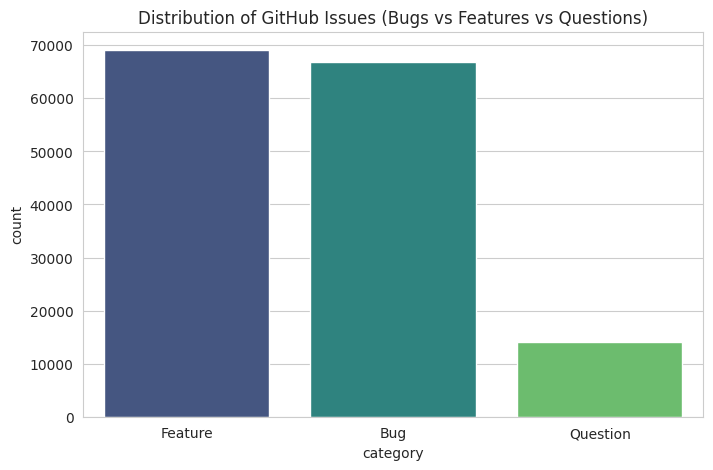

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(x='category', data=df, palette='viridis')
plt.title('Distribution of GitHub Issues (Bugs vs Features vs Questions)')
plt.show()

In [13]:
print(df['category'].value_counts())

category
Feature     69106
Bug         66827
Question    14067
Name: count, dtype: int64


## Step 3 & 4: Cleaning & The "10 Algorithms" Loop

Setup NLTK

In [14]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text Cleaning Function

In [15]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

# We combine Title + Description for better context
df['clean_text'] = (df['title'] + " " + df['description']).apply(clean_text)

TF-IDF Feature Extraction

In [16]:
print("Vectorizing data...")
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['target']

Vectorizing data...


Train-Test Split (80-20)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define the 10 Algorithms

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial NB": MultinomialNB(),
    "Bernoulli NB": BernoulliNB(),
    "Linear SVC": LinearSVC(dual=False),
    "SGD Classifier": SGDClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=50, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(n_estimators=30)
}

The Training Loop

In [19]:
results = []
print("\nStarting Training Loop of 10 Algorithms...")
print("="*60)
print(f"{'Algorithm':<25} | {'Accuracy':<10} | {'Macro F1':<10} | {'Time (s)':<10}")
print("-" * 60)

for name, model in models.items():
    start_time = time.time()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    end_time = time.time()
    duration = end_time - start_time

    results.append({'Algorithm': name, 'Accuracy': acc, 'F1': f1, 'Time': duration})
    print(f"{name:<25} | {acc:.4f}     | {f1:.4f}     | {duration:.2f}")

print("="*60)


Starting Training Loop of 10 Algorithms...
Algorithm                 | Accuracy   | Macro F1   | Time (s)  
------------------------------------------------------------
Logistic Regression       | 0.7532     | 0.6250     | 28.72
Multinomial NB            | 0.7160     | 0.5139     | 0.12
Bernoulli NB              | 0.6388     | 0.5546     | 0.13
Linear SVC                | 0.7489     | 0.6127     | 15.79
SGD Classifier            | 0.7478     | 0.5339     | 1.63
Ridge Classifier          | 0.7477     | 0.5981     | 8.10
Decision Tree             | 0.6428     | 0.5315     | 335.40
Random Forest             | 0.7444     | 0.5611     | 418.02
Extra Trees               | 0.7479     | 0.5580     | 736.51
AdaBoost                  | 0.6142     | 0.4390     | 31.75


## Step 5: Fine-Tuning DistilBERT

Prepare Data for BERT

In [30]:
import os

In [31]:
os.environ["WANDB_DISABLED"] = "true"

In [32]:
df_subset = df.sample(n=20000, random_state=42)

df_subset = df_subset.rename(columns={'target': 'labels'})

hf_dataset = Dataset.from_pandas(df_subset[['title', 'description', 'labels']])

dataset_split = hf_dataset.train_test_split(test_size=0.2)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

Fine-Tuning DistilBERT

In [33]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [34]:
def preprocess_function(examples):
    # Combine title and description
    text_inputs = [str(t) + " " + str(d) for t, d in zip(examples['title'], examples['description'])]
    return tokenizer(text_inputs, truncation=True, padding=True, max_length=128)

print("Tokenizing data...")
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Tokenizing data...


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [35]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

In [38]:
print("Starting BERT Training...")
trainer.train()

Starting BERT Training...


Epoch,Training Loss,Validation Loss
1,0.503100,0.491349


TrainOutput(global_step=1000, training_loss=0.6087426567077636, metrics={'train_runtime': 273.3592, 'train_samples_per_second': 58.531, 'train_steps_per_second': 3.658, 'total_flos': 529879044096000.0, 'train_loss': 0.6087426567077636, 'epoch': 1.0})

In [39]:
print("Evaluating BERT Model...")
results = trainer.evaluate()
print(results)

Evaluating BERT Model...


{'eval_loss': 0.49134936928749084, 'eval_runtime': 16.946, 'eval_samples_per_second': 236.043, 'eval_steps_per_second': 14.753, 'epoch': 1.0}


Get the Accuracy Score

In [40]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

trainer.compute_metrics = compute_metrics

print("Calculating Accuracy...")
final_results = trainer.evaluate()
print(f"Final Accuracy: {final_results['eval_accuracy']:.4f}")
print(f"Final F1 Score: {final_results['eval_f1']:.4f}")

Calculating Accuracy...


Final Accuracy: 0.8130
Final F1 Score: 0.7288


In [41]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [42]:
print("Loading FLAN-T5... (This might take 30-60 seconds)")
gen_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
gen_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to('cuda') # Move to GPU

Loading FLAN-T5... (This might take 30-60 seconds)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [43]:
def smart_triage_agent(issue_text):
    # --- Part A: Classification (BERT) ---
    inputs = tokenizer(issue_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to('cuda')

    with torch.no_grad():
        logits = model(**inputs).logits

    # Get Label (0: Bug, 1: Feature, 2: Question)
    predicted_class_id = logits.argmax().item()
    labels = {0: 'Bug 🐞', 1: 'Feature Request 🚀', 2: 'Question ❓'}
    predicted_label = labels[predicted_class_id]

    # --- Part B: Generation (FLAN-T5) ---
    if predicted_class_id == 0:
        prompt = f"Suggest a code fix or troubleshooting steps for this software bug: {issue_text}"
    elif predicted_class_id == 1:
        prompt = f"Write a polite response acknowledging this feature request: {issue_text}"
    else:
        prompt = f"Answer this technical question concisely: {issue_text}"

    input_ids = gen_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    outputs = gen_model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    response = gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

    return predicted_label, response

print("Agent Ready!")

Agent Ready!


In [44]:
# Test Case 1: A Python Error (Bug)
issue_1 = "I am getting a ZeroDivisionError when I try to calculate the average score with an empty list."

# Test Case 2: A Feature Request
issue_2 = "Can you please add a Dark Mode to the user interface? It hurts my eyes at night."

# Test Case 3: A Question
issue_3 = "How do I install this library using pip?"

# Run the Agent
print("--- TESTING THE AGENT ---")
print(f"Issue: {issue_1}")
label, reply = smart_triage_agent(issue_1)
print(f"Category: {label}")
print(f"AI Suggestion: {reply}\n")

print(f"Issue: {issue_2}")
label, reply = smart_triage_agent(issue_2)
print(f"Category: {label}")
print(f"AI Suggestion: {reply}\n")

print(f"Issue: {issue_3}")
label, reply = smart_triage_agent(issue_3)
print(f"Category: {label}")
print(f"AI Suggestion: {reply}\n")

--- TESTING THE AGENT ---
Issue: I am getting a ZeroDivisionError when I try to calculate the average score with an empty list.
Category: Bug 🐞
AI Suggestion: Is there a way to calculate the average score with an empty list?

Issue: Can you please add a Dark Mode to the user interface? It hurts my eyes at night.
Category: Question ❓
AI Suggestion: No, I don't.

Issue: How do I install this library using pip?
Category: Question ❓
AI Suggestion: Using a python script, open the python.py file in the python.py directory.



## Step 6: Save the Best Model

In [45]:
model_path = "./saved_bert_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model saved to {model_path}")

!zip -r bert_model.zip ./saved_bert_model
print("Zipping complete! Check the 'Files' tab on the left to download 'bert_model.zip'.")

Model saved to ./saved_bert_model
  adding: saved_bert_model/ (stored 0%)
  adding: saved_bert_model/tokenizer_config.json (deflated 75%)
  adding: saved_bert_model/config.json (deflated 49%)
  adding: saved_bert_model/model.safetensors (deflated 8%)
  adding: saved_bert_model/tokenizer.json (deflated 71%)
  adding: saved_bert_model/special_tokens_map.json (deflated 42%)
  adding: saved_bert_model/vocab.txt (deflated 53%)
Zipping complete! Check the 'Files' tab on the left to download 'bert_model.zip'.
